In [1]:
# Import necessary packages
using PyPlot
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using AlgebraicMultigrid
using Printf

In [2]:
struct Grid
    x::Vector
    y::Vector
    nx::Int
    ny::Int
    W::Float64
    H::Float64
    dx::Float64
    dy::Float64
    solution::Matrix{Float64}
    rhs::Matrix{Float64}
    residual::Matrix{Float64}
    Grid(W,H,nx,ny) = new(LinRange(0,W,nx),LinRange(0,H,ny),nx,ny,W,H,W/(nx-1),H/(ny-1),zeros(ny,nx),zeros(ny,nx),zeros(ny,nx))
end

function poisson_smoother!(grid::Grid,cycles::Int)
    coef_center = -2/grid.dx^2 -2/grid.dy^2
    coef_right = 1/grid.dx^2
    coef_left = 1/grid.dx^2
    coef_up = 1/grid.dy^2
    coef_down = 1/grid.dy^2
    theta = 1.0;
    cycle = 1
    while cycle <= cycles
        for j in 2:(grid.nx-1)
            for i in 2:(grid.ny-1) # julia is column-major - inner loop over columns
                # in Gauss-Seidel iterations, the solution (s) is updated within each iteration.
                # note that the 1.0 is the (uniform) value of the right hand side, hard-coded for speed.
                this_residual = grid.rhs[i,j] - coef_left*grid.solution[i,j-1] - coef_right*grid.solution[i,j+1] - coef_up*grid.solution[i-1,j] - coef_down*grid.solution[i+1,j] - coef_center*grid.solution[i,j] 
                grid.solution[i,j] += theta*this_residual/coef_center
            end
        end 
        cycle += 1
    end
    for j in 2:(grid.nx-1)
        for i in 2:(grid.ny-1) # julia is column-major - inner loop over columns
            # in Gauss-Seidel iterations, the solution (s) is updated within each iteration.
            # note that the 1.0 is the (uniform) value of the right hand side, hard-coded for speed.
            grid.residual[i,j] = grid.rhs[i,j] - coef_left*grid.solution[i,j-1] - coef_right*grid.solution[i,j+1] - coef_up*grid.solution[i-1,j] - coef_down*grid.solution[i+1,j] - coef_center*grid.solution[i,j] 
        end
    end
end

function poisson_restriction!(fine::Grid,coarse::Grid,mgunit::Int)
    # restriction (fine) -> (coarse)
    coarse.rhs[:,:] = fine.residual[1:mgunit:end,1:mgunit:end]
end

function poisson_prolongation(fine::Grid,coarse::Grid,mgunit::Int)
    dsol = zeros(fine.ny,fine.nx)
    # use bilinear interpolation to go from coarse to fine
    for j in 2:fine.nx-1
        coarse_j = Int( floor( fine.x[j]/coarse.dx )+1 )
        dx = (fine.x[j]-coarse.x[coarse_j])/coarse.dx
        
        for i in 2:fine.ny-1
            coarse_i = Int( floor( fine.y[i]/coarse.dy) + 1)
            dy = (fine.y[i]-coarse.y[coarse_i]) / coarse.dy
            
            dsol[i,j] += (1.0-dx)*(1.0-dy)*coarse.solution[coarse_i,coarse_j]
            dsol[i,j] += (1.0-dx)*(dy)*coarse.solution[coarse_i+1,coarse_j]
            dsol[i,j] += (dx)*(1.0-dy)*coarse.solution[coarse_i,coarse_j+1]
            dsol[i,j] += (dx)*(dy)*coarse.solution[coarse_i+1,coarse_j+1]
        end
    end
    return dsol
end



poisson_prolongation (generic function with 1 method)

In [10]:
grids[2].rhs
grids[1].residual

81×51 Matrix{Float64}:
 0.0  0.0          0.0          …   0.0           0.0          0.0
 0.0  0.00902303   0.00496364       0.00590756    0.00425161   0.0
 0.0  0.00429419  -0.0174994       -0.0119457    -0.00336333   0.0
 0.0  0.0218228    0.00541046       0.00883283    0.00833322   0.0
 0.0  0.0103404   -0.0296363       -0.0204082    -0.00495535   0.0
 0.0  0.0338173    0.00638034   …   0.0111145     0.012151     0.0
 0.0  0.016891    -0.0383225       -0.0274129    -0.00573422   0.0
 0.0  0.0447688    0.00790833       0.0125409     0.0156382    0.0
 0.0  0.0239145   -0.0432253       -0.0328311    -0.00561293   0.0
 0.0  0.0545358    0.00999223       0.0130207     0.0187561    0.0
 0.0  0.0312942   -0.044411     …  -0.0366713    -0.00460474   0.0
 0.0  0.0630619    0.0125847        0.0125692     0.0214901    0.0
 0.0  0.0388547   -0.0422653       -0.0390506    -0.00280276   0.0
 ⋮                              ⋱                              ⋮
 0.0  0.0582497    0.00568013       0.008

In [4]:
grids[2].solution
figure()
pcolor(grids[2].solution)
colorbar()
show()
figure()

colorbar()
show()

LoadError: UndefVarError: grids not defined

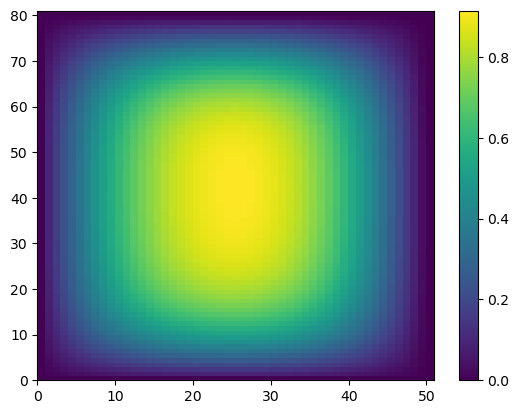

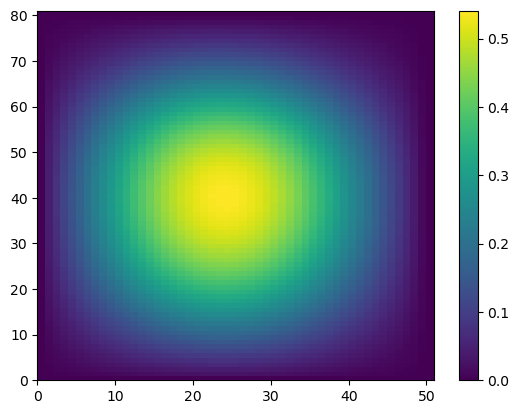

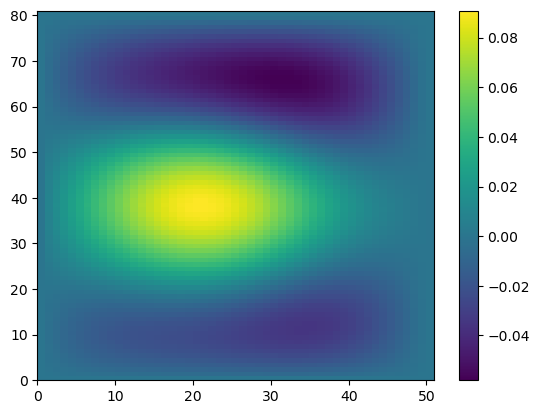

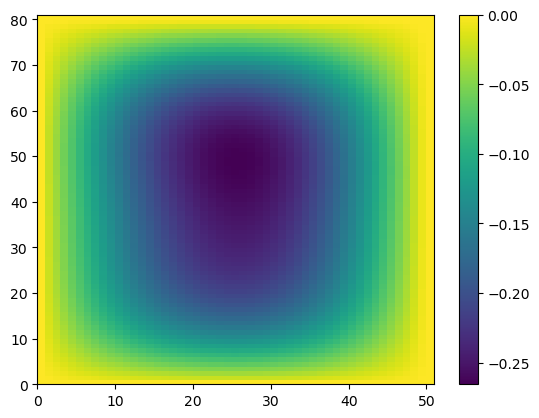

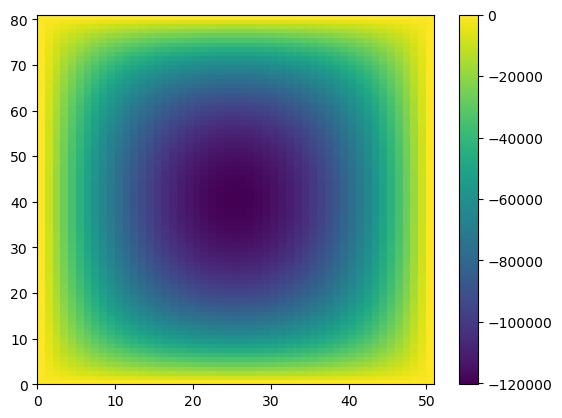

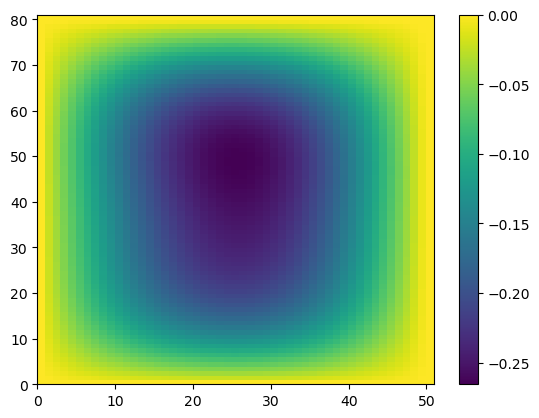

51 81
26 41
1 40
33.7478939446126
1 40
15.560729559452723
1 40
2.055115784252688
1 40
9.13216168733066


In [12]:
# define an indexing function that maps from (i,j) node numbering to an integer index
nx = 61
ny = 81
width = 1e3
height = 1.5e3

# Define levels of grid
nlevel=3
mgunit=2
grids = Vector{Grid}()
cycles = Vector{Int}()
for level in 1:nlevel
    level_nx = Int((nx-1)/mgunit^(level-1)+1)
    level_ny = Int((ny-1)/mgunit^(level-1)+1)
    println(level_nx,' ', level_ny)
    push!(grids, Grid(width,height,level_nx,level_ny) )
    push!(cycles,2^(nlevel-level+1)*10)
end

# set RHS for finest grid.
level = 1
for i in 2:grids[level].ny-1
    for j in 2:grids[level].nx-1
        grids[level].rhs[i,j] = 1.0        
    end
end
    
level = 1
outer_cycles = 4
cycle = 1
# outer solver iterations
while cycle <= outer_cycles
    for level in 1:nlevel-1
        println(level,' ',cycles[level])
        poisson_smoother!(grids[level],cycles[level])     
        poisson_restriction!(grids[level],grids[level+1],mgunit)
    end
    # end at grid level nlevel-1
    # compute correction to current solution using a direct solver
    # interpolate corrections onto finer grids
    for level in nlevel:-1:2
        poisson_smoother!(grids[level],cycles[level])
        dsol = poisson_prolongation(grids[level-1],grids[level],mgunit)
        grids[level-1].solution[:,:] += dsol[:,:]
         # interpolate correction from level+1 onto level
    end
    poisson_smoother!(grids[1],cycles[1]) # run smoother once without updating solution to compute residual
    figure()
    pcolor(grids[1].residual)
    colorbar()
    show()
    println(norm(grids[1].residual))
    cycle += 1 # increment mg cycle counter
end

figure()
pcolor(grids[1].solution)
colorbar()
show()
figure()
pcolor(grids[1].residual)
colorbar()
show()

In [6]:
# pre-allocate arrays to store indices and values
row_index = zeros(Int64,5*nn) # up to 5 nonzeros per row
col_index = zeros(Int64,5*nn)
values = zeros(Float64, 5*nn)
R = zeros(Float64,nn,1)
k=1
for i in 1:ny
    for j in 1:nx
        row = dof(i,j)
        coef_center = -2/dx^2 -2/dy^2
        coef_right = 1/dx^2
        coef_left = 1/dx^2
        coef_up =   1/dy^2
        coef_down = 1/dy^2
        # modify equations for dirichlet boundary condition f=0:
        if i==1 || i == ny || j==1 || j == nx
            row_index[k] = row;  col_index[k] = row;  values[k] = coef_center;
            R[row] = coef_center*0.0
            k+=1
        else        
            # center:
            row_index[k] = row
            col_index[k] = dof(i,j)
            values[k] = coef_center
            k+=1
            # left:
            row_index[k] = row
            col_index[k] = dof(i,j-1)
            values[k] = coef_left
            k += 1

            row_index[k] = row
            col_index[k] = dof(i,j+1)
            values[k] = coef_right
            k += 1

            row_index[k] = row
            col_index[k] = dof(i-1,j)
            values[k] = coef_up
            k+=1

            row_index[k] = row
            col_index[k] = dof(i+1,j)
            values[k] = coef_down
            k+=1
            R[row] = 1.
        end
    end
end
@views row_index = row_index[1:(k-1)]
@views col_index = col_index[1:(k-1)]
@views values = values[1:(k-1)]

L = sparse(row_index,col_index,values)
@time solution = L\R
solution = reshape(solution,ny,nx)

x = LinRange(0,width,nx)
y = LinRange(0,height,ny)
figure()
contourf(x,y,solution,20)
gca().set_aspect("equal")
colorbar(label="\$\\Psi\$ (km\$^2\$)")
xlabel("Position (km)")
ylabel("Position (km)")
show()

figure()
ind = Integer(750/dy)+1
plot(x,solution[ind,:])
title(@sprintf "Transect at %g km depth" y[ind])
xlabel("Position (km)")
ylabel("\$\\Psi\$ (km\$^2\$)")
show()

LoadError: UndefVarError: nn not defined